In [1]:
# import sys
# sys.path.append('fnc')
import matplotlib.pyplot as plt
from fnc.plot import plotTrajectory, plotClosedLoopLMPC, plot_predicted_trajectory, animation_states, saveGif_xyResults
from initControllerParameters import initMPCParams, initLMPCParams
from fnc.PredictiveControllers import MPC, LMPC, MPCParams
from fnc.PredictiveModel import PredictiveModel
from fnc.Utilities import Regression, PID
from fnc.Track import Map
import numpy as np
import pickle
import pdb
import sys,os
sys.path.append(sys.path[0]+'/../../utils/')
from simulators import *

In [2]:
# ======================================================================================================================
# ============================================= Initialize parameters  =================================================
# ======================================================================================================================
N = 14                                    # Horizon length
n = 6;   d = 2                            # State and Input dimension
x0 = [0.5, 0, 0, 0, 0, 0]                 # Initial condition

dt = 0.1

map = Map(0.4)                            # Initialize map
vt = 0.8                                  # target vevlocity

# Initialize controller parameters
mpcParam, ltvmpcParam = initMPCParams(n, d, N, vt)
numSS_it, numSS_Points, Laps, TimeLMPC, QterminalSlack, lmpcParameters = initLMPCParams(map, N)

# Init simulators
simulator = SIMULATOR("dyn_bicycle_model", map=map, dt=0.1)


In [3]:
# ======================================================================================================================
# ======================================= PID path following ===========================================================
# ======================================================================================================================
print("Starting PID")
# Initialize pid and run sim
PIDController = PID(vt)
t_max = 1000

xcl_pid = [x0]
xcl_pid_glob = [x0]
ucl_pid = []

for time in range(t_max):
    # read measurement
    xt = xcl_pid[time] 

    # Solve LMPC
    PIDController.solve(xt) 

    # Apply input and store closed-loop data
    ut = PIDController.uPred[:,0]
    ucl_pid.append(ut.tolist())
    x_next = simulator.sim([xcl_pid[time], xcl_pid_glob[time]], ut) # Simulate both in global and local coordinates
    xcl_pid.append(x_next[0])
    xcl_pid_glob.append(x_next[1])

    # increment time counter
    time += 1


Starting PID


In [4]:
# ======================================================================================================================
# ==============================  LMPC w\ LOCAL LINEAR REGRESSION ======================================================
# ======================================================================================================================
print("Starting LMPC")
# Initialize Predictive Model for lmpc
predictiveModel = PredictiveModel(n, d, map, 4)
for i in range(0,4): # add trajectories used for model learning
    predictiveModel.addTrajectory(np.array(xcl_pid)[:-1,:], np.array(ucl_pid))

# Initialize Controller
lmpcParameters.timeVarying     = True 
lmpc = LMPC(numSS_Points, numSS_it, QterminalSlack, lmpcParameters, predictiveModel)
for i in range(0,numSS_it): # add trajectories for safe set
    lmpc.addTrajectory( np.array(xcl_pid)[:-1,:], np.array(ucl_pid), np.array(xcl_pid_glob)[:-1,:])

# Run sevaral laps
for it in range(numSS_it, Laps):
    time = 0
    if it == numSS_it:
        xcl = [x0]
        xcl_glob = [x0]
    else:
        x_final = xcl[-1]
        x_start = x_final[:]
        x_start[4] = x_start[4] - map.TrackLength
        xcl = [x_start]
        xcl_glob = [xcl_glob[-1]]
    ucl = []
    while (xcl[-1][4] <= map.TrackLength): # Simulate one lap
            # Read measurement
            xt = xcl[time] 
            
            # Solve LMPC
            lmpc.solve(xcl[-1])
            ut = lmpc.uPred[0,:]
                        
            # Run simulation
            xt, xt_glob = simulator.sim([xcl[-1], xcl_glob[-1]], ut)

            # Add points
            ucl.append(ut)
            lmpc.addPoint(np.array(xcl[-1]), np.array(ucl[-1])) # This is needed to extend the safe set beyond the finish line
            xcl.append(xt)
            xcl_glob.append(xt_glob)
                
            # Update time
            time += 1
    
    # Add trajectory to controller
    lmpc.addTrajectory( np.array(xcl)[:-1,:], np.array(ucl), np.array(xcl_glob)[:-1,:])
    predictiveModel.addTrajectory(np.array(xcl)[:-1,:], np.array(ucl))              
    print("Completed lap: ", it, " in ", np.round(lmpc.Qfun[it][0]*dt, 2)," seconds")

print("===== LMPC terminated")
    

Starting LMPC
Completed lap:  4  in  21.3  seconds
Completed lap:  5  in  17.7  seconds
Completed lap:  6  in  15.3  seconds
Completed lap:  7  in  13.5  seconds
Completed lap:  8  in  12.2  seconds
Completed lap:  9  in  11.4  seconds
Completed lap:  10  in  10.6  seconds
Completed lap:  11  in  10.0  seconds
Completed lap:  12  in  9.4  seconds
Completed lap:  13  in  9.2  seconds
Completed lap:  14  in  8.8  seconds
Completed lap:  15  in  8.6  seconds
Completed lap:  16  in  8.2  seconds
Completed lap:  17  in  8.0  seconds
Completed lap:  18  in  8.1  seconds
Completed lap:  19  in  7.9  seconds
Completed lap:  20  in  7.7  seconds
Completed lap:  21  in  7.4  seconds
Completed lap:  22  in  7.5  seconds
Completed lap:  23  in  7.5  seconds
Completed lap:  24  in  7.2  seconds
Completed lap:  25  in  7.5  seconds
Completed lap:  26  in  7.4  seconds
Completed lap:  27  in  7.4  seconds
Completed lap:  28  in  7.2  seconds
Completed lap:  29  in  7.3  seconds
Completed lap:  30  in

## Plot closed-loop trajectories

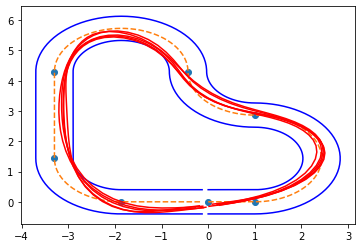

In [5]:
# Plot the last last_laps_to_plot
plotClosedLoopLMPC(lmpc, map, last_laps_to_plot=5)

<Figure size 432x288 with 0 Axes>

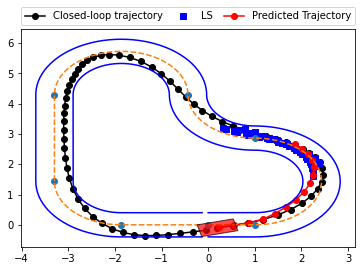

<Figure size 432x288 with 0 Axes>

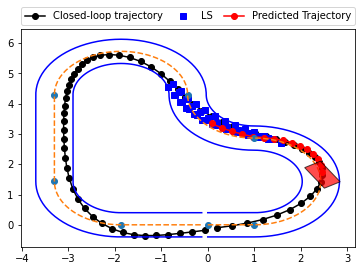

<Figure size 432x288 with 0 Axes>

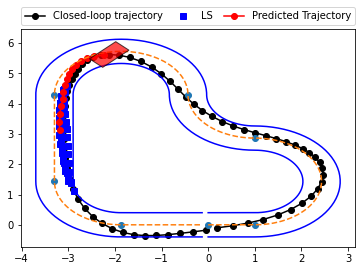

In [6]:
# Plot the predicted trajectory (red), the closed-loop trajectory (black), and the local safe set (blue)
time = 0
plot_predicted_trajectory(map, lmpc, Laps-2, time)

time = 10
plot_predicted_trajectory(map, lmpc, Laps-2, time)

time = 35
plot_predicted_trajectory(map, lmpc, Laps-2, time)